In [1]:
import numpy
from matplotlib import pyplot as plt
import numpy as np
import scipy

from modules import c

## TOV equation:  (diff-eq approach)
\begin{gather}
    \frac{dP}{dr} = 
    -\frac{G m}{r^2} \rho 
    \left(1 + \frac{P}{\rho c^2}\right) 
    \left(1 + \frac{4 \pi r^3 P}{m c^2}\right)
    \left(1 - \frac{2 G m}{r c^2}\right)^{-1}
\end{gather}

but we want to solve the scaled TOV equations:
\begin{gather}
    \boxed{
    \frac{dp(x)}{dx} = -\frac{1}{2} \frac{\left[\epsilon(x) + p(x))\right]\left[m(x) + 3 x^3 p(x)\right]}{x^2 \left[1 - m(x)/x\right]}
    \\
    \frac{dm(x)}{dx} = 3 x^2 \epsilon(x)
    }
\end{gather}

In [2]:
Epsilon_naught = 1.285  # GeV / fm^3

def epsilon(p_of_x, m_of_x):
    # eps_of_p = np.sqrt((p_of_x * c) ** 2 + (m_of_x * c) ** 2)
    eps_of_p = np.sqrt((p_of_x * 1) ** 2 + (m_of_x * 1) ** 2)
    
    return eps_of_p

def m(x, p_of_x):
    return 4 * np.pi * x**2 * p_of_x

In [3]:
n = 1_000

x, dx = np.linspace(0, 100, n, retstep=True)  # units? lets use meters for now  -- just kidding it's solar masses
x[0] = 1e-9  # some eps

from my scattering code:

```python

def full_radial_schrodinger_eqn(r_value, u, theta):

    return np.array([
                     u[1], 
                     ( 
                      (l * (l + 1)) / ((r_value) ** 2)  + 
                      ((2 * mass) / (hbarc ** 2) ) * (  theta[0] * np.exp(-kappa_r*r_value**2) + theta[1] * np.exp(-kappa_s*r_value**2)  )  - 
                      p2
                      ) * u[0]
                     ])
```

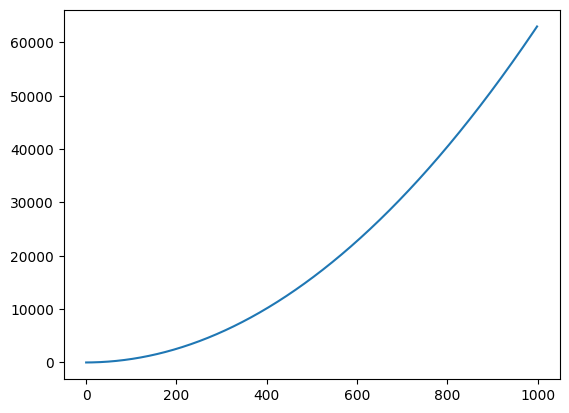

In [19]:
plt.plot(solve_ivp_diffeq(x, x))

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 1.000e-09  1.001e-01 ...  9.990e+01  1.000e+02]
        y: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 1.000e+00  1.738e-02 ...  4.348e-08  4.333e-08]]
      sol: None
 t_events: None
 y_events: None
     nfev: 344
     njev: 0
      nlu: 0


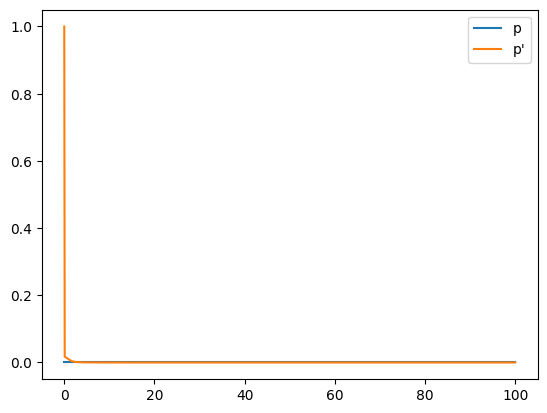

In [24]:
def solve_ivp_diffeq(x, p):
    return np.array([p[0], -0.5 * (epsilon(p[1], m(x, p[1])) + p[1]) * (m(x, p[1]) + 3 * x * p[1]) / (x**2 * (1 - m(x, p[1]) / x))])

solve_ivp_result = scipy.integrate.solve_ivp(solve_ivp_diffeq, (x[0], x[-1]), (0., 1.), t_eval=x)
print(solve_ivp_result)

p = solve_ivp_result.y[0]
p_pr = solve_ivp_result.y[1]

plt.plot(x, p, label="p")
plt.plot(x, p_pr, label="p'")
# plt.yscale("log")
plt.legend()
plt.show()

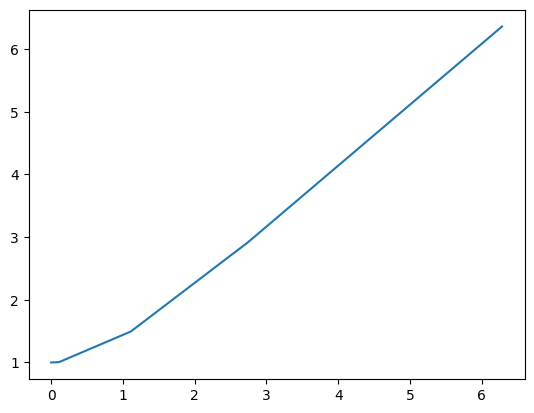

In [13]:
from scipy.integrate import solve_ivp

# Define the ODE

def dydt(t, y):
    return t / y

# Initial condition
y0 = [1]

# Time span

t_span = (0, np.pi * 2)

# Solve the ODE

solution = solve_ivp(dydt, t_span, y0)

plt.plot(solution.t, solution.y[0, :])
plt.show()

## TOV equation(s): (integral-eq approach)

\begin{gather}
    \frac{dp}{dr} = -\frac{G \rho(r) \mathcal{M}(r)}{r^2}
    \\
    \frac{d\mathcal{M}}{dr} = 4 \pi^2 \rho(r)
    \\
    \mathcal{M}(r) = 4 \pi \int_0^r r'^2 \rho(r') dr'
\end{gather}

## lets make a first-order ODE solver using rk4

In [81]:
def first_order_rk4(x: np.array, y0: float, y0_pr: float, ode_func, *ode_func_args):
    """
    rk4 solver using the equations that I
    shamelessly ripped from:
    https://www.intmath.com/differential-equations/12-runge-kutta-rk4-des.php
    
    Parameters
    ----------
    x: numpy array
        Mesh for solver
    y0: 
        Initial point for y
    y0_pr: an empty array
        Initial value for derivative
    ode_func: function
        The function that will be solved.
        The form should be:
        d^2/dx^2 y = ode_func(x, y, *ode_func_args) 
    ode_func_args : tuple (optional)
        Args for ode_func
    
    Returns
    -------
    y_pr : numpy array
        The solution to the given ODE as given by
        rk4.
    """
    n = len(x)
    dx = x[1] - x[0]  # THIS ASSUMES A LINEAR MESH !!
    half_dx = dx / 2
    # initialize return array & set initial value(s)
    y = np.empty(n)
    y[0] = y0
    y[1] = y0_pr
    
    for i in np.arange(1, n-1):       
        F_1 = dx * ode_func(x[i], y[i], *ode_func_args)
        F_2 = dx * ode_func(x[i] + half_dx, y[i] + F_1 / 2, *ode_func_args)
        F_3 = dx * ode_func(x[i] + half_dx, F_2 / 2, *ode_func_args)
        F_4 = dx * ode_func(x[i+1], y[i] + F_3, *ode_func_args)
        
        y[i + 1] = ode_func(x[i], y[i], *ode_func_args) + ((1 / 6) * (F_1 + 2 * F_2 + 3 * F_3 + F_4))
    
    return y

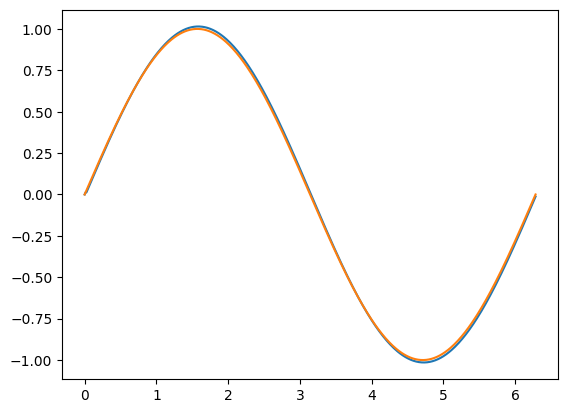

In [89]:
def test_ode_func(x, y):
    return np.sin(x)


x, dx = np.linspace(0, 2 * np.pi, 500, retstep=True)

y = first_order_rk4(x, 0, dx, test_ode_func)

plt.plot(x, y)
plt.plot(x, np.sin(x))
plt.show()

In [70]:
y[:5]

array([0.        , 0.12822827, 0.25645654, 0.30076699, 0.44013776])